In [ ]:
import os
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import Image, display
from pathlib import Path

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/irinalazar/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
DATASET_PATH = "constellation_dataset"

In [11]:
def explore_dataset(dataset_path):
    """Function to explore the YOLOv8 format dataset structure"""
    print(f"Exploring dataset at: {dataset_path}")
    
    # Check if the path exists
    if not os.path.exists(dataset_path):
        print(f"Error: Path {dataset_path} does not exist")
        return
    
    # Check for data.yaml file
    yaml_path = os.path.join(dataset_path, "data.yaml")
    if os.path.exists(yaml_path):
        print(f"Found data.yaml at {yaml_path}")
        with open(yaml_path, 'r') as f:
            data_config = yaml.safe_load(f)
            print("\nData Config:")
            print(f"- Train path: {data_config.get('train')}")
            print(f"- Val path: {data_config.get('val')}")
            print(f"- Test path: {data_config.get('test', 'Not specified')}")
            print(f"- Number of classes: {data_config.get('nc')}")
            print(f"- Classes: {data_config.get('names')}")
    else:
        print(f"Warning: data.yaml not found at {yaml_path}")

    for split in ["train", "valid", "test"]:
        split_dir = os.path.join(dataset_path, split)
        if os.path.exists(split_dir):
            images_dir = os.path.join(split_dir, "images")
            labels_dir = os.path.join(split_dir, "labels")
            
            if os.path.exists(images_dir) and os.path.exists(labels_dir):
                image_count = len([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
                label_count = len([f for f in os.listdir(labels_dir) if f.endswith('.txt')])
                print(f"\n{split.capitalize()} set:")
                print(f"- Images: {image_count}")
                print(f"- Labels: {label_count}")
                
                if image_count > 0:
                    # Show example image
                    sample_image = os.path.join(images_dir, os.listdir(images_dir)[0])
                    print(f"- Sample image: {sample_image}")
            else:
                print(f"\n{split.capitalize()} set: Missing images or labels directory")
        else:
            print(f"\n{split.capitalize()} set: Directory not found")

In [12]:
explore_dataset(DATASET_PATH)

Exploring dataset at: constellation_dataset
Found data.yaml at constellation_dataset/data.yaml

Data Config:
- Train path: ../train/images
- Val path: ../valid/images
- Test path: ../test/images
- Number of classes: 12
- Classes: ['Aquarius', 'Aries', 'Cancer', 'Capricornus', 'Gemini', 'Leo', 'Libra', 'Pisces', 'Sagittarius', 'Scorpius', 'Taurus', 'Virgo']

Train set:
- Images: 449
- Labels: 449
- Sample image: constellation_dataset/train/images/Scorpius_second_60_jpg.rf.10679592cbd00b16c59c7b0f187fd735.jpg

Valid set:
- Images: 128
- Labels: 128
- Sample image: constellation_dataset/valid/images/Sagittarius_first_120_jpg.rf.c42b7437a9000a3803f1e3e2d23018d3.jpg

Test set:
- Images: 65
- Labels: 65
- Sample image: constellation_dataset/test/images/Cancer_third_300_jpg.rf.7a993216cb9f284ee14cc27a3439c732.jpg


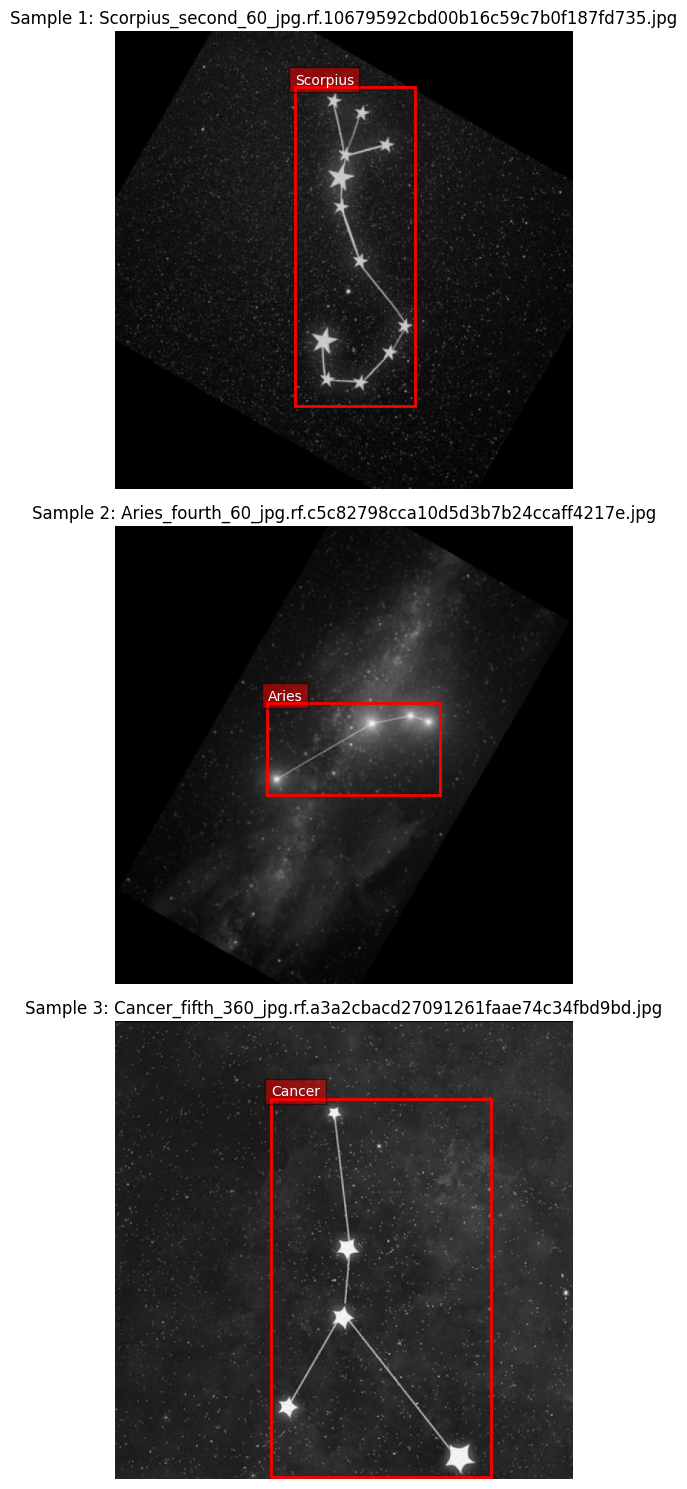

In [14]:
def visualize_samples(dataset_path, num_samples=3):
    """Visualize sample images with their annotations"""
    train_images_dir = os.path.join(dataset_path, "train", "images")
    train_labels_dir = os.path.join(dataset_path, "train", "labels")
    
    # Load class names from data.yaml
    yaml_path = os.path.join(dataset_path, "data.yaml")
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    class_names = data_config.get('names')
    
    # Get a list of image files
    image_files = [f for f in os.listdir(train_images_dir) if f.endswith(('.jpg'))]
    
    # Select sample images (either randomly or first few)
    samples = image_files[:num_samples]
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, sample in enumerate(samples):
        # Load image and get dimensions
        img_path = os.path.join(train_images_dir, sample)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape
        
        # Load corresponding label file
        label_file = os.path.splitext(sample)[0] + '.txt'
        label_path = os.path.join(train_labels_dir, label_file)
        
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                
            for line in lines:
                parts = line.strip().split()
                class_id, x_center, y_center, w, h = map(float, parts)
                class_id = int(class_id)
                
                # Convert normalized coordinates to pixel values
                x_center, y_center = x_center * width, y_center * height
                w, h = w * width, h * height
                
                # Calculate bounding box coordinates
                x1 = int(x_center - w/2)
                y1 = int(y_center - h/2)
                x2 = int(x_center + w/2)
                y2 = int(y_center + h/2)
                
                # Draw bounding box
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
                plt.gca().add_patch(rect)
                
                # Add class label
                class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                plt.text(x1, y1-5, class_name, color='white', fontsize=10, 
                         bbox=dict(facecolor='red', alpha=0.5))
        
        plt.title(f"Sample {i+1}: {sample}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Visualize sample training images with annotations
try:
    visualize_samples(DATASET_PATH)
except Exception as e:
    print(f"Error visualizing samples: {e}")

In [15]:
def enhance_star_visibility(image):
    """
    Enhance star visibility in constellation images using multiple techniques
    
    Args:
        image: Input image (BGR format from cv2.imread)
    
    Returns:
        Enhanced image
    """
    # Convert to grayscale for some processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 1. Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray)
    
    # 2. Increase contrast using gamma correction
    gamma = 0.7  # Values < 1 will enhance bright regions (stars)
    gamma_corrected = np.array(255 * (clahe_img / 255) ** gamma, dtype=np.uint8)
    
    # 3. Apply slight Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gamma_corrected, (3, 3), 0)
    
    # 4. Apply sharpening filter to enhance stars
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    sharpened = cv2.filter2D(blurred, -1, kernel)
    
    # 5. Apply threshold to further enhance bright spots (stars)
    _, thresh = cv2.threshold(sharpened, 150, 255, cv2.THRESH_TOZERO)
    
    # Convert back to color for visualization
    enhanced = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    
    return enhanced

Visualizing sample images with star visibility enhancement:


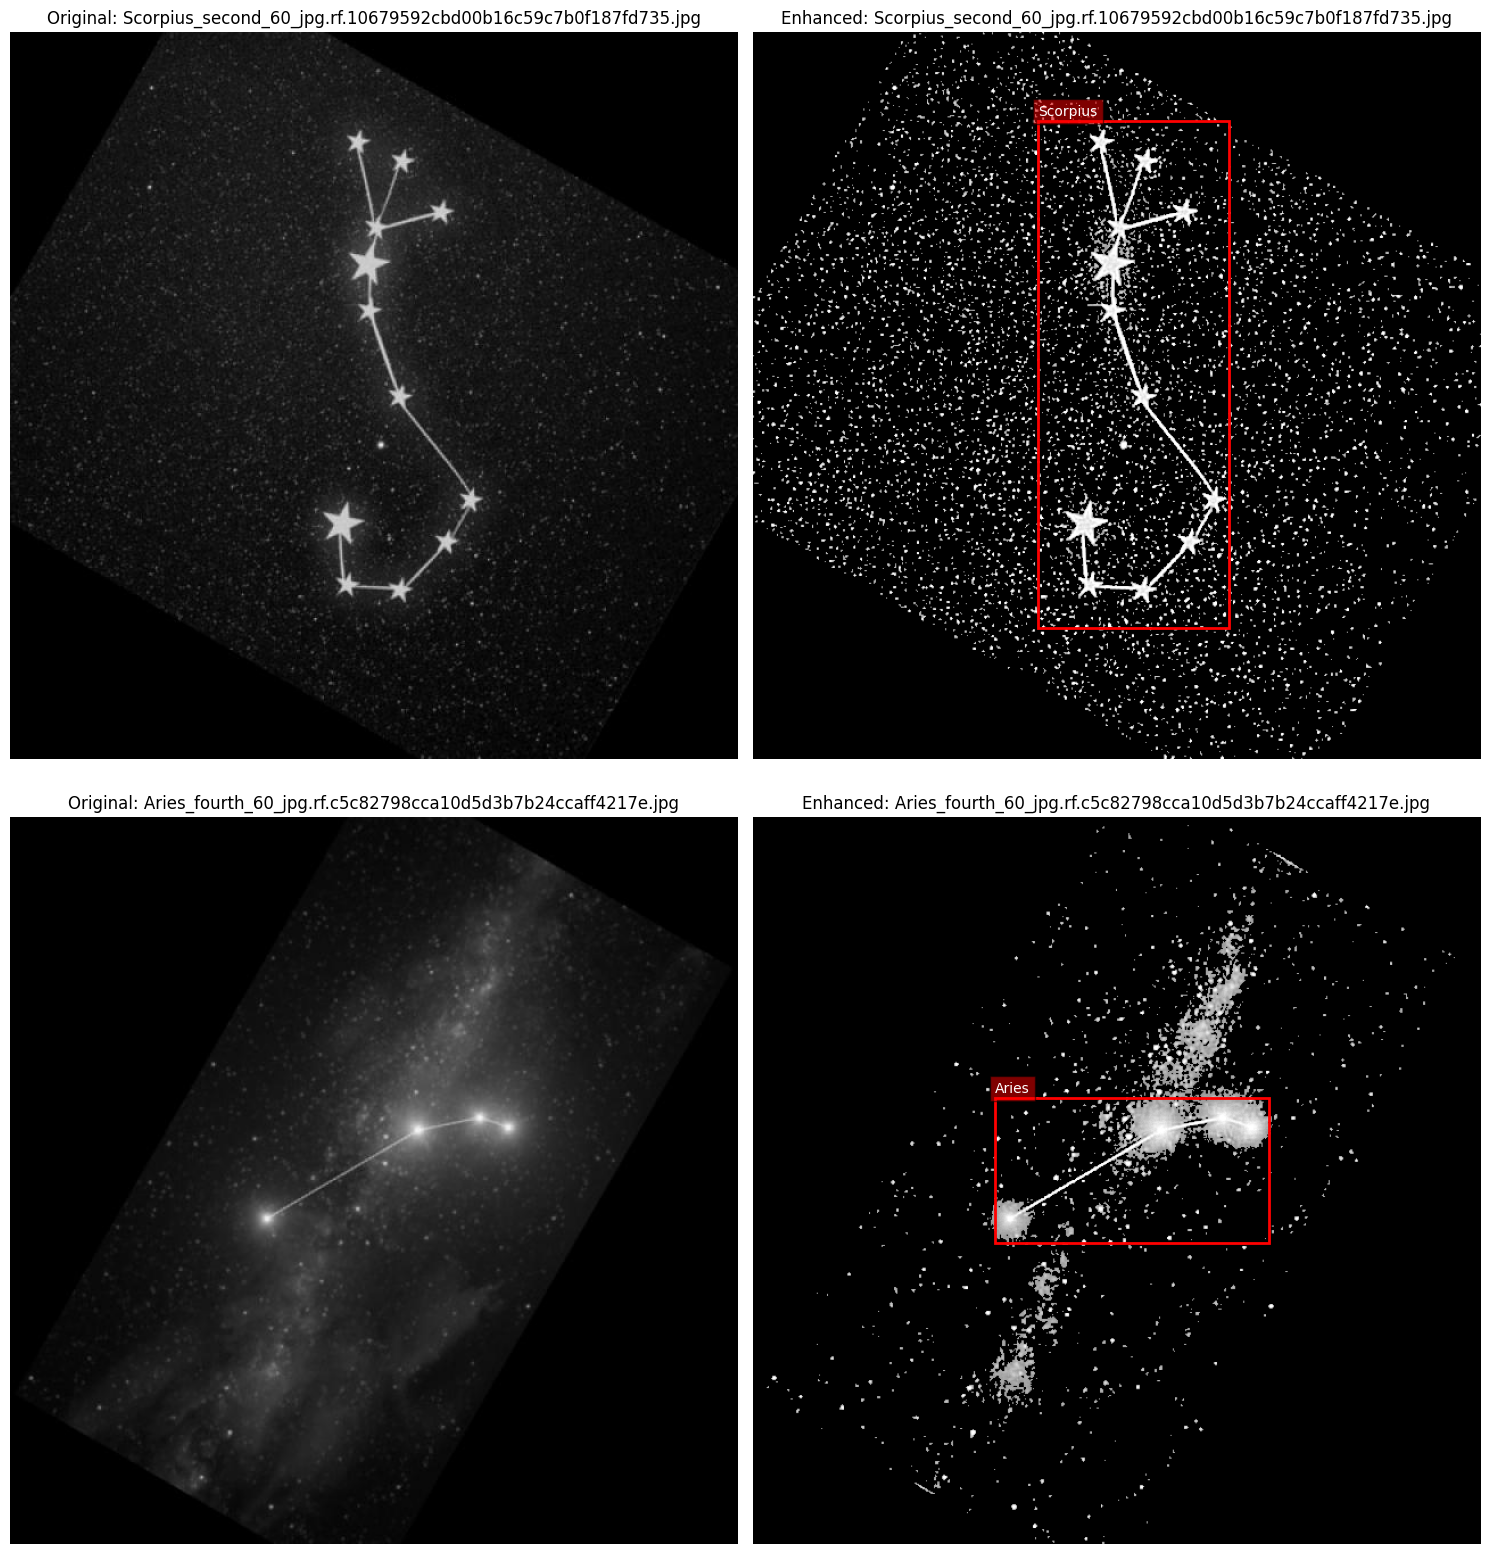

In [16]:
def visualize_samples(dataset_path, num_samples=3, apply_enhancement=True):
    """Visualize sample images with their annotations and optional enhancement"""
    train_images_dir = os.path.join(dataset_path, "train", "images")
    train_labels_dir = os.path.join(dataset_path, "train", "labels")
    
    # Load class names from data.yaml
    yaml_path = os.path.join(dataset_path, "data.yaml")
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    class_names = data_config.get('names')
    
    # Get a list of image files
    image_files = [f for f in os.listdir(train_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Select sample images (either randomly or first few)
    samples = image_files[:num_samples]
    
    plt.figure(figsize=(15, 8 * num_samples))
    
    for i, sample in enumerate(samples):
        # Load image and get dimensions
        img_path = os.path.join(train_images_dir, sample)
        img = cv2.imread(img_path)
        height, width, _ = img.shape
        
        # Create enhanced version if requested
        if apply_enhancement:
            enhanced_img = enhance_star_visibility(img)
            
            # Display original image
            plt.subplot(num_samples, 2, i*2+1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Original: {sample}")
            plt.axis('off')
            
            # Display enhanced image
            plt.subplot(num_samples, 2, i*2+2)
            plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Enhanced: {sample}")
            plt.axis('off')
            
            # Use enhanced image for annotation
            img_display = enhanced_img.copy()
        else:
            plt.subplot(num_samples, 1, i+1)
            img_display = img.copy()
            plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
            plt.title(f"Sample {i+1}: {sample}")
            plt.axis('off')
        
        # Load corresponding label file
        label_file = os.path.splitext(sample)[0] + '.txt'
        label_path = os.path.join(train_labels_dir, label_file)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                
            for line in lines:
                parts = line.strip().split()
                class_id, x_center, y_center, w, h = map(float, parts)
                class_id = int(class_id)
                
                # Convert normalized coordinates to pixel values
                x_center, y_center = x_center * width, y_center * height
                w, h = w * width, h * height
                
                # Calculate bounding box coordinates
                x1 = int(x_center - w/2)
                y1 = int(y_center - h/2)
                x2 = int(x_center + w/2)
                y2 = int(y_center + h/2)
                
                # Draw bounding box on appropriate subplot
                if apply_enhancement:
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
                    plt.subplot(num_samples, 2, i*2+2).add_patch(rect)
                    
                    # Add class label
                    class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                    plt.subplot(num_samples, 2, i*2+2).text(x1, y1-5, class_name, color='white', fontsize=10, 
                                bbox=dict(facecolor='red', alpha=0.5))
                else:
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
                    plt.gca().add_patch(rect)
                    
                    # Add class label
                    class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                    plt.text(x1, y1-5, class_name, color='white', fontsize=10, 
                             bbox=dict(facecolor='red', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Visualize sample training images with annotations and enhancements
try:
    print("Visualizing sample images with star visibility enhancement:")
    visualize_samples(DATASET_PATH, num_samples=2, apply_enhancement=True)
except Exception as e:
    print(f"Error visualizing samples: {e}")